# Text mining: Predir l'ocupació


In [ ]:
import pandas as pd
import requests, io
import numpy as np
import seaborn as sns

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Read Data

In [ ]:
data = pd.read_csv('https://github.com/paubernabe/data/blob/main/juliol.csv?raw=true')
print(data.shape)
data.head(5)

(17079, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,18674,https://www.airbnb.com/rooms/18674,20210707180233,2021-07-07,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,https://www.airbnb.com/users/show/71615,Mireia And Maria,2010-01-19,"Barcelona, Catalonia, Spain","We are Mireia (43) & Maria (45), two multiling...",within an hour,98%,81%,f,https://a0.muscache.com/im/users/71615/profile...,https://a0.muscache.com/im/users/71615/profile...,la Sagrada Família,34.0,34.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Barcelona, CT, Spain",la Sagrada Família,Eixample,41.40556,2.17262,Entire apartment,Entire home/apt,8,NaN,2 baths,3.0,6.0,"[""Washer"", ""Host greets you"", ""Iron"", ""Hair dr...",$169.00,1,1125,1.0,3.0,1125.0,1125.0,2.0,1125.0,NaN,t,0,0,0,60,2021-07-07,21,0,0,2014-03-02,2019-10-11,4.40,4.55,4.75,4.80,4.90,4.75,4.30,HUTB-002062,t,18,18,0,0,0.23
1,23197,https://www.airbnb.com/rooms/23197,20210707180233,2021-07-08,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony,"Beautiful spacious apartment, large terrace, 5...",Strategically located in the Parc del Fòrum ar...,https://a0.muscache.com/pictures/738532/806da1...,90417,https://www.airbnb.com/users/show/90417,Etain (Marnie),2010-03-09,"Catalonia, Spain","Hi. I'm Etain, though everyone calls me by my...",within a few hours,100%,67%,f,https://a0.muscache.com/im/users/90417/profile...,https://a0.muscache.com/im/users/90417/profile...,El Besòs i el Maresme,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Sant Adria de Besos, Barcelona, Spain",el Besòs i el Maresme,Sant Martí,41.41291,2.22063,Entire apartment,Entire home/apt,6,NaN,2 baths,3.0,5.0,"[""Washer"", ""Iron"", ""Hair dryer"", ""Security cam...",$240.00,3,300,3.0,6.0,1125.0,1125.0,3.5,1125.0,NaN,t,17,47,77,169,2021-07-08,52,0,0,2016-01-05,2019-12-15,4.74,4.92,4.92,4.94,4.98,4.67,4.69,HUTB-005057,f,2,2,0,0,0.78
2,32711,https://www.airbnb.com/rooms/32711,20210707180233,2021-07-08,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/357b25e4-f414...,135703,https://www.airbnb.com/users/show/135703,Nick,2010-05-31,"Barcelona, Catalonia, Spain",I'm Nick your English host in Barcelona.\r\n\r...,within a day,83%,100%,f,https://a0.muscache.com/im/users/135703/profil...,https://a0.muscache.com/im/users/135703/profil...,Camp d'en Grassot i Gràcia Nova,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Barcelona, Catalonia, Spain",el Camp d'en Grassot i Gràcia Nova,Gràcia,41.40566,2.1

In [ ]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [ ]:
calendar = pd.read_csv('https://github.com/paubernabe/data/blob/main/calendar_july.csv.gz?raw=true', compression='gzip')
print(calendar.shape)
calendar.head(5)

(6233476, 7)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,275889,2021-07-07,f,$287.00,$287.00,32.0,365.0
1,71736,2021-07-08,t,$62.00,$62.00,32.0,730.0
2,71736,2021-07-09,t,$62.00,$62.00,32.0,730.0
3,71736,2021-07-10,t,$62.00,$62.00,32.0,730.0
4,71736,2021-07-11,t,$62.00,$62.00,32.0,730.0


In [ ]:
print('We have', calendar.date.nunique(), 'days and', calendar.listing_id.nunique(), 'unique listings in the calendar data.')

We have 368 days and 17078 unique listings in the calendar data.


In [ ]:
calendar.date.min(), calendar.date.max()

('2021-07-07', '2022-07-09')

## Clean data

In [ ]:
#drop useless columns
data = data.drop(['scrape_id', 'last_scraped', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                  'host_neighbourhood', 'bathrooms', 'calendar_updated'],axis=1)

In [ ]:
def clean_str(x):
    if (type(x) == str):
      x = x.replace("$", "").replace(",", "").replace(" ", "").replace("%", "")
    return float(x)


#listing data

d = {'t': True, 'f': False}
data['host_has_profile_pic'] = data['host_has_profile_pic'].map(d)
data['host_is_superhost'] = data['host_is_superhost'].map(d)  
data['host_identity_verified'] = data['host_identity_verified'].map(d)
data['has_availability'] = data['has_availability'].map(d)
data['instant_bookable'] = data['instant_bookable'].map(d)

data['price'] = data['price'].apply(clean_str)
data['host_acceptance_rate'] = data['host_acceptance_rate'].apply(clean_str)
data['host_response_rate'] = data['host_response_rate'].apply(clean_str)

In [ ]:
def haversine_distance(lat1, lon1):
   r = 6371
   lat2 = 41.3870154 #pl catalunya
   lon2 = 2.1700471
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [ ]:
data['distance'] = data.apply(lambda row : haversine_distance(row['latitude'],
                                  row['longitude']), axis = 1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


8.58287955969319 30 0 3.0


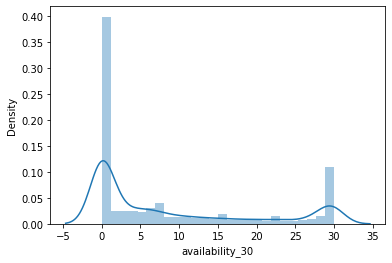

In [ ]:
sns.distplot(data['availability_30'])
print(data['availability_30'].mean(), data['availability_30'].max(), data['availability_30'].min(), data['availability_30'].median())

In [ ]:
def bar_plot_object(title,data):
  x = list(data.value_counts().keys())
  x = x[::-1]
  y = list(data.value_counts())
  y = y[::-1]
  plt.barh(x,y)
  plt.title(title)
  return None


def explore_col(data, column):
  bar_plot_object(column+" histogram",data[column])
  print(column,'description\n', data[column].describe())
  print('Top 5 frequent:',data[column].value_counts()[:5].index.tolist())


### Data engineering
- Dummy variables

In [ ]:
#new categorical columns
y = pd.get_dummies(data.room_type, prefix='rt')
type(y)
data = data.join(y)

y = pd.get_dummies(data.property_type, prefix='property')
type(y)
data = data.join(y)

y = pd.get_dummies(data.host_is_superhost, prefix='superhost')
type(y)
data = data.join(y)

y = pd.get_dummies(data.neighbourhood_group_cleansed, prefix='nb')
type(y)
data = data.join(y)

y = pd.get_dummies(data.instant_bookable, prefix='ib')
type(y)
data = data.join(y)


In [ ]:
# Get the ground truth --> real ocupation in August
calendar_aug = calendar
date_mask_aug = (calendar_aug['date'] >= '2021-08-01') & (calendar_aug['date'] <= '2021-08-31')
calendar_aug = calendar_aug[date_mask_aug]
y = calendar_aug[['listing_id', 'available']]
y['busy'] = y.available.map( lambda x: 0 if x == 't' else 1)

y = y.groupby('listing_id').agg({'busy': np.sum})

y = y.reset_index(drop = False)
y.columns = ['id', 'busy_august']

y.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,busy_august
0,18674,31
1,23197,0
2,32711,31
3,34241,31
4,34981,18


In [ ]:
df = pd.merge(data, y, on='id')

In [ ]:
df.head()

,id,listing_url,name,description,neighborhood_overview,picture_url,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,...,property_Private room in house,property_Private room in loft,property_Private room in serviced apartment,property_Private room in tiny house,property_Private room in townhouse,property_Private room in vacation home,property_Private room in villa,property_Room in aparthotel,property_Room in bed and breakfast,property_Room in boutique hotel,property_Room in hostel,property_Room in hotel,property_Room in serviced apartment,property_Shared room in apartment,property_Shared room in bed and breakfast,property_Shared room in condominium,property_Shared room in floor,property_Shared room in guest suite,property_Shared room in guesthouse,property_Shared room in hostel,property_Shared room in hotel,property_Shared room in house,property_Shared room in loft,property_Shared room in serviced apartment,property_Tiny house,superhost_False,superhost_True,nb_Ciutat Vella,nb_Eixample,nb_Gràcia,nb_Horta-Guinardó,nb_Les Corts,nb_Nou Barris,nb_Sant Andreu,nb_Sant Martí,nb_Sants-Montjuïc,nb_Sarrià-Sant Gervasi,ib_False,ib_True,busy_august
0,18674,https://www.airbnb.com/rooms/18674,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,2010-01-19,within an hour,98.0,81.0,False,34.0,34.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",True,True,"Barcelona, CT, Spain",la Sagrada Família,Eixample,41.40556,2.17262,Entire apartment,Entire home/apt,8,2 baths,3.0,6.0,"[""Washer"", ""Host greets you"", ""Iron"", ""Hair dr...",169.0,1,1125,1.0,3.0,1125.0,1125.0,2.0,1125.0,True,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,31
1,23197,https://www.airbnb.com/rooms/23197,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony,"Beautiful spacious apartment, large terrace, 5...",Strategically located in the Parc del Fòrum ar...,https://a0.muscache.com/pictures/738532/806da1...,2010-03-09,within a few hours,100.0,67.0,False,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",True,True,"Sant Adria de Besos, Barcelona, Spain",el Besòs i el Maresme,Sant Martí,41.41291,2.22063,Entire apartment,Entire home/apt,6,2 baths,3.0,5.0,"[""Washer"", ""Iron"", ""Hair dryer"", ""Security cam...",240.0,3,300,3.0,6.0,1125.0,1125.0,3.5,1125.0,True,17,47,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,32711,https://www.airbnb.com/rooms/32711,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/357b25e4-f414...,2010-05-31,within a day,83.0,100.0,False,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",True,True,"Barcelona, Catalonia, Spain",el Camp d'en Grassot i Gràcia Nova,Gràcia,41.40566,2.17015,Entire apartment,Entire home/apt,6,1.5 baths,2.0,3.0,"[""Washer"", ""Iron"", ""Hair dryer"", ""Security cam...",144.0,2,31,2.0,2.0,31.0,31.0,2.0,31.0,True,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,31
3,34241,https://www.airbnb.com/rooms/34241,Private Double room - Plaza Real,<b>The space</b><br />It is a Private double r...,NaN,https://a0.muscache.com/pictures/2437facc-2fe7...,2010-01-24,within a few hours,100.0,83.0,True,3.0,3.0,"['email', 'phone', 'reviews', 'manua

In [ ]:
datanum = df._get_numeric_data()
'''corrmat = datanum.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(100,100))
#plot heat map
sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")'''

'corrmat = datanum.corr()\ntop_corr_features = corrmat.index\nplt.figure(figsize=(100,100))\n#plot heat map\nsns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")'

In [ ]:
df['bathrooms_text'].value_counts()

1 bath               6570
1 shared bath        3625
2 baths              2783
1 private bath       1171
1.5 shared baths      780
1.5 baths             734
2 shared baths        584
3 baths               214
2.5 baths             122
4 baths                77
2.5 shared baths       69
3 shared baths         55
3.5 baths              39
0 shared baths         39
Shared half-bath       32
Half-bath              23
5 baths                23
0 baths                23
6 baths                15
3.5 shared baths       14
11 shared baths        14
5.5 baths              12
4 shared baths         10
4.5 baths               6
Private half-bath       5
7.5 baths               4
7 shared baths          3
8 baths                 3
5 shared baths          2
8 shared baths          2
4.5 shared baths        2
7.5 shared baths        1
16 baths                1
7 baths                 1
6.5 baths               1
Name: bathrooms_text, dtype: int64

In [ ]:
import re

def parse_bathroom_shared(x):
  if type(x) == str:
    if 'shared' in x.lower():
      b = re.findall("\d+", x)
      if len(b) == 0:
        return float('nan')
      if len(b) == 1:
        return int(b[0])
      if len(b) > 1:
        return float(b[0]) + float('0.'+b[1])
  return 0

def parse_bathroom(x):
  if type(x) == str:
    if 'shared' not in x.lower():
      b = re.findall("\d+", x)
      if len(b) == 0:
        return float('nan')
      if len(b) == 1:
        return int(b[0])
      if len(b) > 1:
        return float(b[0]) + float('0.'+b[1])
  return 0
  

df['private_bath'] = df['bathrooms_text'].apply(parse_bathroom)
df['shared_bath'] = df['bathrooms_text'].apply(parse_bathroom_shared)




In [ ]:
df['private_bath'].value_counts()

1.0     7741
0.0     5274
2.0     2783
1.5      734
3.0      214
2.5      122
4.0       77
3.5       39
5.0       23
6.0       15
5.5       12
4.5        6
7.5        4
8.0        3
6.5        1
7.0        1
16.0       1
Name: private_bath, dtype: int64

In [ ]:
df['shared_bath'].value_counts()

0.0     11885
1.0      3625
1.5       780
2.0       584
2.5        69
3.0        55
11.0       14
3.5        14
4.0        10
7.0         3
5.0         2
4.5         2
8.0         2
7.5         1
Name: shared_bath, dtype: int64

In [ ]:
df.head()['distance']

0    2.07
1    5.11
2    2.07
3    0.83
4    0.96
Name: distance, dtype: float64

In [ ]:
cols = ['review_scores_rating','review_scores_accuracy','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin' ,'review_scores_communication', 'review_scores_location', 'review_scores_value']


datanum[cols] = datanum[cols].fillna(0)

In [ ]:
datanum =datanum.drop(['availability_60', 'availability_90', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_nights_avg_ntm'], axis=1)


In [ ]:
transport = pd.read_csv('https://github.com/paubernabe/data/blob/main/TRANSPORTS.csv?raw=true')
print(transport.shape)
transport.head(5)

(642, 16)


,CODI_CAPA,CAPA_GENERICA,NOM_CAPA,ED50_COORD_X,ED50_COORD_Y,ETRS89_COORD_X,ETRS89_COORD_Y,LONGITUD,LATITUD,EQUIPAMENT,DISTRICTE,BARRI,NOM_DISTRICTE,NOM_BARRI,ADRECA,TELEFON
0,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,428480.365,4586484.614,428388.453,4586283.641,2.142987,41.424923,"METRO (L3, L5) - VALL D'HEBRON (C. de les Bass...",7.0,41.0,Horta-Guinardó,la Vall d'Hebron,NaN,NaN
1,K002,Transports i serveis relacionats,Ferrocarrils Generalitat (FGC),429726.943,4582853.670,429635.018,4582652.730,2.158326,41.392331,FGC - PROVENÇA (C. de Provença)-,2.0,8.0,Eixample,l'Antiga Esquerra de l'Eixample,NaN,NaN
2,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,426477.889,4583649.008,426385.994,4583448.062,2.119370,41.399203,FGC (L6) - REINA ELISENDA (Sortida Duquesa d'O...,5.0,23.0,Sarrià-Sant Gervasi,Sarrià,NaN,NaN
3,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,427818.595,4583478.761,427726.688,4583277.816,2.135427,41.397791,FGC (L6) - LA BONANOVA-,5.0,26.0,Sarrià-Sant Gervasi,Sant Gervasi - Galvany,NaN,NaN
4,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,432051.444,4589400.176,431959.500,4589199.175,2.185391,41.451492,METRO (L11) - CASA DE L'AIGUA (C. Vila-Real)-,8.0,53.0,Nou Barris,la Trinitat Nova,NaN,NaN


In [ ]:
tr = transport['NOM_DISTRICTE'].value_counts()

numtransp = pd.DataFrame([tr]).T
numtransp =numtransp.reset_index()
numtransp.columns = ['name', 'number']
numtransp

,name,number
0,Eixample,120
1,Sant Martí,70
2,Sarrià-Sant Gervasi,57
3,Sants-Montjuïc,53
4,Sant Andreu,40
5,Nou Barris,39
6,Horta-Guinardó,31
7,Ciutat Vella,27
8,Les Corts,24
9,Gràcia,17


In [ ]:
def transport_num(x):
  if type(x) == str:
    tmp = numtransp.loc[numtransp['name'] == x]
    return tmp['number'].values[0]
  return 0

df['transport'] = df['neighbourhood_group_cleansed'].apply(transport_num)

In [ ]:
restaurants = pd.read_csv('https://github.com/paubernabe/data/blob/main/rest.csv?raw=true')
print(restaurants.shape)
restaurants.head(5)

(2504, 36)


,register_id,name,institution_id,institution_name,created,modified,addresses_roadtype_id,addresses_roadtype_name,addresses_road_id,addresses_road_name,addresses_start_street_number,addresses_end_street_number,addresses_neighborhood_id,addresses_neighborhood_name,addresses_district_id,addresses_district_name,addresses_zip_code,addresses_town,addresses_main_address,addresses_type,values_id,values_attribute_id,values_category,values_attribute_name,values_value,values_outstanding,values_description,secondary_filters_id,secondary_filters_name,secondary_filters_fullpath,secondary_filters_tree,secondary_filters_asia_id,geo_epgs_25831_x,geo_epgs_25831_y,geo_epgs_4326_x,geo_epgs_4326_y
0,﻿2122182514,Restaurant Chido One,NaN,NaN,2002-05-02T00:00:00+02:00,2021-03-03T22:14:06.509761+01:00,NaN,NaN,341908,C Torrijos,30.0,NaN,31,la Vila de Gràcia,6,Gràcia,8012,BARCELONA,True,NaN,134757.0,20001.0,Telèfons,Tel.,932850335,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,429706.567847,4.583870e+06,41.403301,2.159041
1,﻿2064171550,Labona Pizza *Gal·lileu,NaN,NaN,2002-03-05T00:00:00+01:00,2021-07-21T12:29:38.986716+02:00,NaN,NaN,138802,Carrer de Galileu,326.0,NaN,19,les Corts,4,Les Corts,8028,Barcelona,True,NaN,134615.0,20001.0,Telèfons,Tel.,933222040,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,427366.054990,4.581993e+06,41.386187,2.131268
2,﻿99400276550,Restaurant Pez Vela Chiringuito,NaN,NaN,2011-09-02T12:07:02+02:00,2021-03-03T22:14:28.487962+01:00,NaN,NaN,701644,Pg Mare Nostrum,19.0,NaN,3,la Barceloneta,1,Ciutat Vella,8039,BARCELONA,True,NaN,224661.0,20001.0,Telèfons,Tel.,932216317,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,432247.321931,4.580054e+06,41.369151,2.189861
3,﻿99400264196,Restaurant Udon *Glòries,NaN,NaN,2011-02-07T00:00:00+01:00,2021-03-03T22:14:49.237116+01:00,NaN,NaN,144601,Av Diagonal,208.0,NaN,66,el Parc i la Llacuna del Poblenou,10,Sant Martí,8018,BARCELONA,True,NaN,223254.0,20001.0,Telèfons,Tel.,934861314,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,432506.888609,4.584029e+06,41.404976,2.192521
4,﻿75990341919,Bar Restaurant Marcelino 16 *Diputació,NaN,NaN,1996-09-18T00:00:00+02:00,2021-03-03T22:14:35.713828+01:00,NaN,NaN,100800,C Diputació,41.0,NaN,9,la Nova Esquerra de l'Eixample,2,Eixample,8015,BARCELONA,True,NaN,149688.0,20001.0,Telèfons,Tel.,934246267,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,429109.288208,4.581221e+06,41.379388,2.152206


In [ ]:
tr = restaurants['addresses_district_name'].value_counts()

rest = pd.DataFrame([tr]).T
rest =rest.reset_index()
rest.columns = ['name', 'number']
rest

,name,number
0,Eixample,846
1,Ciutat Vella,558
2,Sarrià-Sant Gervasi,273
3,Sant Martí,198
4,Gràcia,191
5,Sants-Montjuïc,189
6,Les Corts,115
7,Sant Andreu,63
8,Horta-Guinardó,46
9,Nou Barris,25


In [ ]:
def restaurants_num(x):
  if type(x) == str:
    tmp = rest.loc[rest['name'] == x]
    if tmp.empty:
      return 0
    return tmp['number'].values[0]
  return 0

df['restaurants'] = df['neighbourhood_group_cleansed'].apply(restaurants_num)

## TF - IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

english_stop = stopwords.words('english')
spanish_stop = stopwords.words('spanish')

stop = english_stop + spanish_stop

df = df[df['amenities'].notna()]
df = df[df['name'].notna()]
df = df[df['description'].notna()]
print(df.shape)
def clean_text(x):

    '''#will replace the html characters with " "
    text=re.sub('<.*?>', ' ', x)
    #To remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    #will consider only alphabets and numerics
    text = re.sub('[^a-zA-Z]',' ',text)  
    #will replace newline with space
    text = re.sub("\n"," ",text)
    #will convert to lower case
    text = text.lower()
    # will split and join the words
    #text=' '.join(text.split())'''

    x = re.sub('<.*?>', ' ', x)
    x = re.sub(r'\w*\d\w*', '', x)
    x = x.translate(str.maketrans(' ',' ',string.punctuation))
    x = re.sub("\n"," ",x)
    x = x.lower()
    
    t = ''
    for word in x.split():
      if word not in stop and not word.isdigit() and word.isalpha():
        t += ' ' + word
    return t

df['amenities'] = df['amenities'].apply(clean_text)
df['name'] = df['name'].apply(clean_text)
df['description'] = df['description'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(16937, 143)


TF IDF Amenities

In [ ]:
#max_df=0.9, min_df=0.01
v = TfidfVectorizer(max_df=0.9, min_df=0.1)
x = v.fit_transform(df['amenities'])

dfw = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
global_top10_idx = x.toarray().max(axis=0).argsort()[-10:]
words = np.asarray(v.get_feature_names())[global_top10_idx]
words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['workspace', 'dedicated', 'tv', 'cable', 'elevator', 'kitchen',
       'heating', 'washer', 'shampoo', 'hangers'], dtype='<U13')

In [ ]:
dfw = dfw[words]

dfw

,workspace,dedicated,tv,cable,elevator,kitchen,heating,washer,shampoo,hangers
0,0.172171,0.172171,0.140239,0.000000,0.174426,0.122234,0.135851,0.133311,0.165035,0.131523
1,0.106653,0.106653,0.086872,0.000000,0.108050,0.075719,0.084154,0.082580,0.102232,0.081473
2,0.103314,0.103314,0.168305,0.412154,0.104667,0.073348,0.081519,0.079995,0.099032,0.078922
3,0.000000,0.000000,0.252661,0.618732,0.157128,0.110111,0.122378,0.000000,0.000000,0.000000
4,0.086098,0.086098,0.140259,0.343475,0.087226,0.061126,0.067936,0.066665,0.082530,0.065771
...,...,...,...,...,...,...,...,...,...,...
16932,0.303003,0.303003,0.246806,0.000000,0.000000,0.215118,0.239084,0.000000,0.290445,0.231467
16933,0.000000,0.000000,0.134448,0.000000,0.167224,0.117187,0.130242,0.127807,0.000000,0.126092
16934,0.171677,0.171677,0.000000,0.000000,0.000000,0.121883,0.000000,0.000000,0.000000,0.000000
16935,0.000000,0.000000,0.305788,0.000000,0.380332,0.266528,0.000000,0.290681,0.000000,0.286783


In [ ]:
df = pd.concat([df.reset_index(drop=True), dfw.reset_index(drop=True)], axis=1)

TF IDF NAME

In [ ]:
v = TfidfVectorizer(max_df=0.95, min_df=0.05)
x = v.fit_transform(df['name'])

dfw_name = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
global_top10_idx = x.toarray().max(axis=0).argsort()[-10:]
words = np.asarray(v.get_feature_names())[global_top10_idx]
words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['center', 'double', 'familia', 'gracia', 'habitación', 'near',
       'private', 'room', 'sagrada', 'terrace'], dtype='<U10')

In [ ]:
df = pd.concat([df.reset_index(drop=True), dfw_name.reset_index(drop=True)], axis=1)

TF IDF DESCRIPTION

In [ ]:
v = TfidfVectorizer(max_df=0.95, min_df=0.1)
x = v.fit_transform(df['description'])

dfw_desc = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
global_top10_idx = x.toarray().max(axis=0).argsort()[-10:]
words = np.asarray(v.get_feature_names())[global_top10_idx]
words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['piso', 'flat', 'gracia', 'sagrada', 'room', 'habitación', 'metro',
       'plaza', 'space', 'wifi'], dtype='<U11')

In [ ]:
df = pd.concat([df.reset_index(drop=True), dfw_desc.reset_index(drop=True)], axis=1)

In [ ]:
df

,id,listing_url,name,description,neighborhood_overview,picture_url,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,...,located,location,machine,metro,minutes,modern,need,nice,note,number,one,people,perfect,piso,place,plaza,private,quiet,ramblas,renovated,restaurants,room,rooms,sagrada,shower,single,sofa,space,spacious,station,stay,terrace,things,towels,tv,two,walk,walking,well,wifi
0,18674,https://www.airbnb.com/rooms/18674,huge flat people close sagrada familia,apartment rent barcelona located eixample dis...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,2010-01-19,within an hour,98.0,81.0,False,34.0,34.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",True,True,"Barcelona, CT, Spain",la Sagrada Família,Eixample,41.405560,2.172620,Entire apartment,Entire home/apt,8,2 baths,3.0,6.0,washer host greets iron hair dryer hangers tv...,169.0,1,1125,1.0,3.0,1125.0,1125.0,2.0,1125.0,True,0,0,...,0.192240,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.100523,0.000000,0.247181,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.147627,0.0,0.000000,0.00000,0.134903,0.283449,0.131245,0.000000,0.061265,0.000000,0.0,0.00000,0.0000,0.000000,0.146231,0.0,0.000000,0.000000,0.0,0.00000,0.222603
1,23197,https://www.airbnb.com/rooms/23197,forum ccib balcony,beautiful spacious apartment large terrace mi...,Strategically located in the Parc del Fòrum ar...,https://a0.muscache.com/pictures/738532/806da1...,2010-03-09,within a few hours,100.0,67.0,False,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",True,True,"Sant Adria de Besos, Barcelona, Spain",el Besòs i el Maresme,Sant Martí,41.412910,2.220630,Entire apartment,Entire home/apt,6,2 baths,3.0,5.0,washer iron hair dryer security cameras prope...,240.0,3,300,3.0,6.0,1125.0,1125.0,3.5,1125.0,True,17,47,...,0.000000,0.132174,0.000000,0.000000,0.119022,0.000000,0.0,0.141713,0.000000,0.000000,0.000000,0.116894,0.0,0.0,0.0,0.000000,0.000000,0.12933,0.000000,0.000000,0.0,0.076735,0.00000,0.000000,0.134046,0.124135,0.123095,0.057946,0.368943,0.0,0.00000,0.2504,0.000000,0.000000,0.0,0.111600,0.126698,0.0,0.00000,0.000000
2,32711,https://www.airbnb.com/rooms/32711,sagrada familia area còrsega,lovely two bedroom apartment barcelonas iconi...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/357b25e4-f414...,2010-05-31,within a day,83.0,100.0,False,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",True,True,"Barcelona, Catalonia, Spain",el Camp d'en Grassot i Gràcia Nova,Gràcia,41.405660,2.170150,Entire apartment,Entire home/apt,6,1.5 baths,2.0,3.0,washer iron hair dryer security cameras prope...,144.0,2,31,2.0,2.0,31.0,31.0,2.0,31.0,True,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.174155,0.000000,0.161201,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.00000,0.195463,0.000000,0.000000,0.000000,0.177537,0.000000,0.0,0.00000,0.0000,0.000000,0.000000,0.0,0.170962,0.000000,0.0,0.00000,0.000000
3,34241,https://www.airbnb.com/rooms/34241,private double room plaza real,space private double room private bathroom ne...,NaN,https://a0.muscache.com/pictures/2437facc-2fe7...,2010-01-24,within a few hours,100.0,83.0,True,3.0,3.0,"['email', 'phone', 'reviews', 'manual_offline'...",True,True,NaN,el Barri Gòtic,Ciutat Vella,41.380620,2.175170,Private room in apartment,Private room,2,1 private bath,1.0,1.0,ove

### Split train and test

In [ ]:
#FEATURE SELECTION

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

select = SelectKBest(score_func=f_regression, k=7)
df_select = datanum.dropna()
y_select = df_select['busy_august']
X_select = df_select.drop('busy_august', axis=1)
z = select.fit_transform(X_select,y_select)
 
print("After selecting best 7 features:", z.shape)


filter = select.get_support()

X_select.columns.values[filter]

After selecting best 7 features: (8148, 7)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


array(['minimum_nights', 'availability_30', 'availability_365',
       'rt_Entire home/apt', 'rt_Private room',
       'property_Entire apartment', 'property_Room in hotel'],
      dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=11) #seed
print(train.shape, test.shape)

(13549, 255) (3388, 255)


In [ ]:
features = ['minimum_nights', 'availability_365','availability_30', 'rt_Entire home/apt', 'distance', 'accommodates', 'private_bath']


X = train[features + ['busy_august']].dropna()
y = X['busy_august']
del X['busy_august']

X_test = test[features + ['busy_august']].dropna()
y_test = X_test['busy_august']
del X_test['busy_august']

In [ ]:
print(X.shape, X_test.shape)

(13529, 9) (3381, 9)


### Model training: KNN

----- EVALUATION ON TRAIN SET ------
RMSE 4.5061733593257856
MAE 2.397265134156257
R^2:  0.8783434666460375


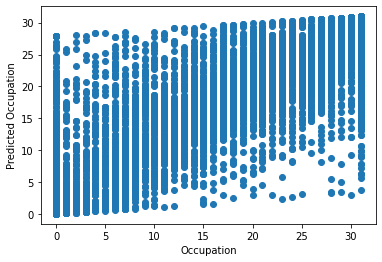

In [ ]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

n_neighbors = 10
knn = neighbors.KNeighborsRegressor(n_neighbors)
knn.fit(X, y)

y_pred = knn.predict(X)


print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y, y_pred)))
print("MAE", mean_absolute_error(y, y_pred))
print("R^2: ",r2_score(y, y_pred))


plt.scatter(y, y_pred)
plt.xlabel('Occupation')
plt.ylabel('Predicted Occupation');
plt.show()

### Model test: KNN

----- EVALUATION ON TEST SET ------
RMSE 5.040549563235942
MAE 2.6903283052351377
R^2:  0.8470236411254031


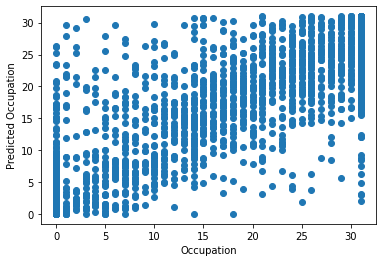

In [ ]:
y_pred_test = knn.predict(X_test)

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE", mean_absolute_error(y_test, y_pred_test))
print("R^2: ",r2_score(y_test, y_pred_test))


plt.scatter(y_test, y_pred_test)
plt.xlabel('Occupation')
plt.ylabel('Predicted Occupation')
plt.show()

## Linear regression train

----- EVALUATION ON TRAIN SET ------
RMSE 7.104802082058326
MAE 5.110084534782754
R^2:  0.6975708741125006


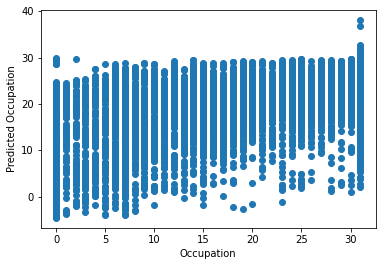

In [ ]:
from sklearn.linear_model import LinearRegression


lr = LinearRegression()

lr.fit(X, y)


y_pred = lr.predict(X)



print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y, y_pred)))
print("MAE", mean_absolute_error(y, y_pred))
print("R^2: ",r2_score(y, y_pred))


plt.scatter(y, y_pred)
plt.xlabel('Occupation')
plt.ylabel('Predicted Occupation');
plt.show()

## Linear regression test

----- EVALUATION ON TEST SET ------
RMSE 7.168460914324289
MAE 5.158093602813413
R^2:  0.6905999468556017


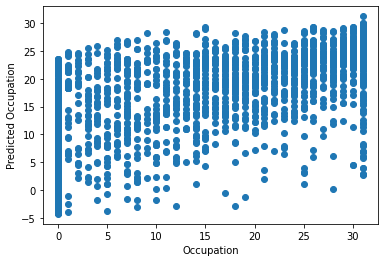

In [ ]:
y_pred_test = lr.predict(X_test)

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE", mean_absolute_error(y_test, y_pred_test))
print("R^2: ",r2_score(y_test, y_pred_test))


plt.scatter(y_test, y_pred_test)
plt.xlabel('Occupation')
plt.ylabel('Predicted Occupation');
plt.show()

## Random forest

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


----- EVALUATION ON TRAIN SET ------
RMSE 1.812546214183181
MAE 0.9748924532485771
R^2:  0.9803167040405902
OOB SCORE 0.8572977581426188


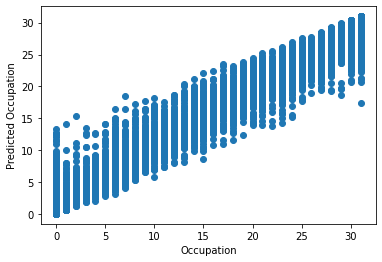

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42, oob_score=True)
# Train the model on training data
rf.fit(X, y)

## predict training set
y_pred = rf.predict(X)


print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y, y_pred)))
print("MAE", mean_absolute_error(y, y_pred))
print("R^2: ",r2_score(y, y_pred))
print('OOB SCORE', rf.oob_score_)


plt.scatter(y, y_pred)
plt.xlabel('Occupation')
plt.ylabel('Predicted Occupation');
plt.show()

## Random forest test

----- EVALUATION ON TEST SET ------
RMSE 4.838101893508734
MAE 2.588784383318545
R^2:  0.8590650966418745


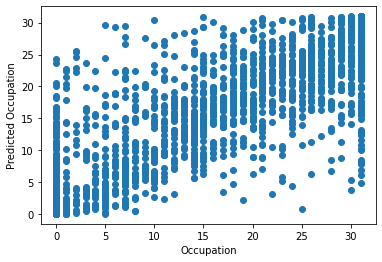

In [ ]:
y_pred_test = rf.predict(X_test)

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE", mean_absolute_error(y_test, y_pred_test))
print("R^2: ",r2_score(y_test, y_pred_test))


plt.scatter(y_test, y_pred_test)
plt.xlabel('Occupation')
plt.ylabel('Predicted Occupation');
plt.show()